In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import yfinance as yf
import plotly.graph_objects as go
from ipywidgets import interact, interactive, fixed, interact_manual

yf.pdr_override()

In [15]:
ibov = web.get_data_yahoo('^BVSP')
ibov

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,24.500000,0
1993-04-28,24.500000,24.600000,23.700001,24.299999,24.299999,0
1993-04-29,24.299999,24.799999,23.700001,23.700001,23.700001,0
1993-04-30,23.700001,24.200001,23.700001,24.100000,24.100000,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,24.100000,0
...,...,...,...,...,...,...
2022-08-29,112296.000000,113222.000000,111689.000000,112323.000000,112323.000000,9795800
2022-08-30,112323.000000,112869.000000,110103.000000,110431.000000,110431.000000,11937900
2022-08-31,110431.000000,111364.000000,109523.000000,109523.000000,109523.000000,14791100


In [9]:
ibov.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-29,112296.0,113222.0,111689.0,112323.0,112323.0,9795800
2022-08-30,112323.0,112869.0,110103.0,110431.0,110431.0,11937900
2022-08-31,110431.0,111364.0,109523.0,109523.0,109523.0,14791100
2022-09-01,109524.0,110405.0,108217.0,110405.0,110405.0,14478000
2022-09-02,110409.0,112264.0,110409.0,110864.0,110864.0,0


<AxesSubplot:xlabel='Date'>

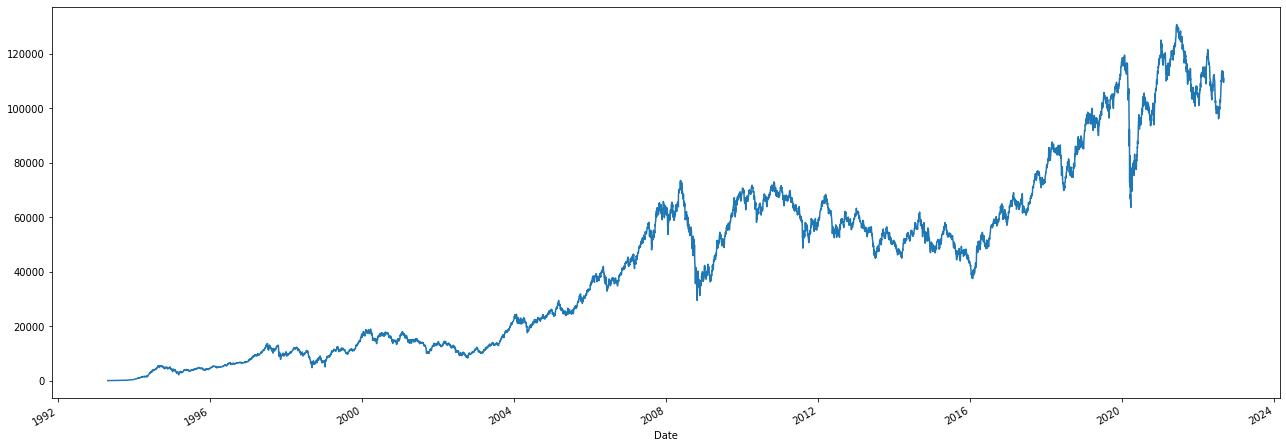

In [10]:
ibov['Adj Close'].plot(figsize=(22,8))

## Fronteira Eficiente na Prática com Python | Otimização de Carteira | Markowitz

https://www.youtube.com/watch?v=ykHxllpCcQw

In [33]:
tickers = ['MGLU3.SA', 'VALE3.SA']
periodo = '1y' # 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max



In [34]:
def fix_col_names(df):
    return ['IBOV' if col == '^BVSP' else col.rstrip('SA') for col in df.columns]

In [35]:
prices = yf.download(tickers, period=periodo, rounding=True)['Adj Close']
prices.columns = fix_col_names(prices)
prices.dropna(inplace=True)
retorno = prices.pct_change().dropna()
ativos = retorno.columns.to_list()


[*********************100%***********************]  2 of 2 completed


In [36]:
prices.tail

<bound method NDFrame.tail of             MGLU3.  VALE3.
Date                      
2021-09-02   18.01   81.73
2021-09-03   18.90   81.78
2021-09-06   19.48   80.50
2021-09-08   18.79   78.82
2021-09-09   18.85   78.54
...            ...     ...
2022-08-29    4.52   66.91
2022-08-30    4.51   64.97
2022-08-31    4.27   64.50
2022-09-01    4.37   63.89
2022-09-02    4.26   62.92

[251 rows x 2 columns]>

In [37]:
# Criando Carteira

def calcula_carteira(df, w1):
    pesos = [w1,(1-w1)]
    df2 = df.dot(pesos).copy()
    return df2.mean() * 252, df2.std() * np.sqrt(252)


In [38]:
carteira = pd.DataFrame()
for i in np.linspace(0,1,101):
    media, std = calcula_carteira(retorno, i)
    carteira.at[i, 'retorno'] = media
    carteira.at[i, 'volatilidade'] = std

carteira

,retorno,volatilidade
0.00,-0.191414,0.380755
0.01,-0.200702,0.377858
0.02,-0.209990,0.375138
0.03,-0.219277,0.372597
0.04,-0.228565,0.370240
...,...,...
0.96,-1.083045,0.783159
0.97,-1.092333,0.790850
0.98,-1.101621,0.798559
0.99,-1.110909,0.806287


In [39]:
# Vol mínima
min_vol_idx = carteira['volatilidade'].idxmin()
min_vol_idx


0.15

In [40]:
# Calcula a fronteira eficiente
if (carteira['retorno'].iloc[0] > carteira['retorno'].iloc[-1]):
  fe = carteira.loc[:min_vol_idx, :]
else:
  fe = carteira.loc[min_vol_idx:, :]


### Gráfico

In [49]:
def gerar_grafico(w1, mostrar_curvas):
    fig = go.Figure()

    # Desenha um ponto com o retorno e a volatilidade da carteira
    fig.add_scatter(y=[carteira.iloc[w1]['retorno']], 
                    x=[carteira.iloc[w1]['volatilidade']], 
                    text=['CARTEIRA'],
                    mode='markers+text', name='CARTEIRA')
    
    # Desenha os pontos das ações individuais
    fig.add_scatter(y=carteira.iloc[[-1,0]]['retorno'], 
                    x=carteira.iloc[[-1,0]]['volatilidade'], 
                    text=ativos,
                    mode='markers+text', name='Ações')
  
    # Desenha a curva
    fig.add_scatter(y=carteira['retorno'], 
                    x=carteira['volatilidade'],                  
                    mode='lines', name='Curva', 
                    visible=mostrar_curvas)

    # Plota carteira de volatilidade mínima   
    fig.add_scatter(y=[carteira.loc[min_vol_idx]['retorno']], 
                    x=[carteira.loc[min_vol_idx]['volatilidade']],                  
                    mode='markers', 
                    name='Carteira de Mínima Variância',
                    visible=mostrar_curvas)
      
    # Desenha a fronteira eficiente
    fig.add_scatter(y=fe['retorno'], 
                    x=fe['volatilidade'],                  
                    mode='lines', name='Fronteira Eficiente', 
                    line={'color':'red'},
                    visible=mostrar_curvas)
                
    fig.update_traces(textfont_size=12, 
                    textposition='top center', 
                    textfont_color='white',
                    hovertemplate='<b>retorno: </b> %{y:.1%}' +
                                  '<br><b>volatilidade:</b> %{x:.1%}')
    fig.layout.autosize = False
    fig.layout.xaxis.title='Volatilidade'
    fig.layout.yaxis.title='Retorno Esperado'
    fig.layout.xaxis.range = [carteira['volatilidade'].min()-0.05, carteira['volatilidade'].max()+0.05]
    fig.layout.yaxis.range = [carteira['retorno'].min()-0.05, carteira['retorno'].max()+0.05]
    fig.layout.xaxis.tickformat = '.0%'
    fig.layout.yaxis.tickformat = '.0%'
    fig.layout.title = f"<b>{ativos[0]}:</b> {w1}%  <b>{ativos[1]}:</b> {100-w1}%"
    fig.layout.template = 'plotly_dark'
                   
    fig.show(config=dict(displayModeBar=True))


In [54]:
interact(gerar_grafico, w1=(0,100, 1), mostrar_curvas=False)

interactive(children=(IntSlider(value=50, description='w1'), Checkbox(value=False, description='mostrar_curvas…

<function __main__.gerar_grafico(w1, mostrar_curvas)>